# Airline Customer Satisfaction Prediction


## 1. Setup and Data Loading

In [29]:
# Import libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Notebook display helpers
from IPython.display import display, HTML

# Model libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

# Explainability
import shap
import lime
from lime.lime_text import LimeTextExplainer
from lime.lime_tabular import LimeTabularExplainer

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [30]:
# Load dataset
data_path = "data/cleaned/AirlineScrappedReview_Cleaned_Enhanced.csv"
df_original = pd.read_csv(data_path)
print(f"Dataset shape: {df_original.shape}")
df_original.head()

Dataset shape: (2805, 22)


,route,rating,verified,review_title,review_content,traveller_type,class,start_location,end_location,layover_route,...,start_address,end_latitude,end_longitude,end_address,sentiment,sentiment_score,start_country,end_country,traveller_class_combo,is_satisfied
0,New Orleans to London,1,Trip Verified,The airline lost my luggage,The airline lost my luggage and was absolutely...,Solo Leisure,Economy Class,New Orleans,London,direct_flight,...,"New Orleans, Orleans Parish, Louisiana, United...",51.507446,-0.127765,"London, Greater London, England, United Kingdom",negative,-0.7990,United States,United Kingdom,Solo Leisure - Economy Class,0
1,London to Amman,1,Trip Verified,fully refunded by our travel insurance,"We booked on the BA website, round trip flight...",Couple Leisure,Business Class,London,Amman,direct_flight,...,"London, Greater London, England, United Kingdom",31.951569,35.923963,"عمان, ناحية عمان, لواء قصبة عمان, عمان, 11110,...",neutral,0.0219,United Kingdom,الأردن,Couple Leisure - Business Class,0
2,Heathrow to Bodrum,2,Trip Verified,no boarding drinks provided,"First time flying with BA business class, neve...",Solo Leisure,Business Class,London Heathrow,Bodrum,direct_flight,...,"London Heathrow Airport, The Beacon Roundabout...",37.034399,27.430651,"Bodrum, Muğla, Ege Bölgesi, Türkiye",negative,-0.7096,United Kingdom,Türkiye,Solo Leisure - Business Class,0
3,Amman to London,4,Not Verified,WiFi didn't work,You can buy sandwiches and crisps but don't ex...,Solo Leisure,Economy Class,Amman,London,direct_flight,...,"عمان, ناحية عمان, لواء قصبة عمان, عمان, 11110,...",51.507446,-0.127765,"London, Greater London, England, United Kingdom",negative,-0.5849,الأردن,United Kingdom,Solo Leisure - Economy Class,0
4,London City to Ibiza,7,Trip Verified,stick with economy,This is a two-for-one review covering economy ...,Family Leisure,Business Class,London City,Ibiza,direct_flight,...,"London (city), Ontario, N6C 0A7, Canada",38.974390,1.419746,"Eivissa, Illes Balears, España",positive,0.9789,Canada,España,Family Leisure - Business Class,1


## 2. Data Preprocessing

In [31]:
# Create a copy for processing
df = df_original.copy()

# Drop unnecessary columns
columns_to_drop = ['review_title', 'start_address',
                   'end_address', 'rating', 'route', 
                   'start_country', 'end_country', 'traveller_class_combo', 'sentiment', 'start_location', 'end_location']

df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)

# Standardize column names early to keep the feature space consistent
df.columns = [col.lower().replace(' ', '_') for col in df.columns]

print("  Preprocessing completed!")
print(f"Final shape: {df.shape}")
print("Columns ready for train/test specific preprocessing.")

  Preprocessing completed!
Final shape: (2805, 11)
Columns ready for train/test specific preprocessing.


## 3. Train-Test Split & Feature Extraction

In [32]:
# Separate features and target
X = df.drop('is_satisfied', axis=1)
y = df['is_satisfied']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nClass distribution in training:")
print(y_train.value_counts(normalize=True))

# Store text column for later use
text_column = 'review_content'

Training set: (2244, 10)
Test set: (561, 10)

Class distribution in training:
is_satisfied
0    0.565954
1    0.434046
Name: proportion, dtype: float64


In [33]:
# Prepare STRUCTURED FEATURES ONLY (without TF-IDF)
# We'll first train models without text features to establish a baseline
print("="*80)
print("PHASE 1: PREPARING STRUCTURED FEATURES ONLY (NO NLP)")
print("="*80)
print("\nPreparing structured features...")

# Work on copies to avoid modifying the original splits
X_train_structured = X_train.drop(columns=[text_column]).copy()
X_test_structured = X_test.drop(columns=[text_column]).copy()

# Store preprocessing artifacts for future reuse/interpretability
preprocessing_artifacts = {}

# Ordinal-encode high-cardinality columns (if they exist) using train fit / test transform
if 'layover_route' in X_train_structured.columns:
    ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X_train_structured[['layover_route']] = ordinal_encoder.fit_transform(X_train_structured[['layover_route']])
    X_test_structured[['layover_route']] = ordinal_encoder.transform(X_test_structured[['layover_route']])
    preprocessing_artifacts['layover_route_encoder'] = ordinal_encoder

# One-hot encode remaining categorical columns by fitting only on training data
categorical_cols = X_train_structured.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
if categorical_cols:
    X_train_structured = pd.get_dummies(X_train_structured, columns=categorical_cols, drop_first=True, dtype=int)
    X_test_structured = pd.get_dummies(X_test_structured, columns=categorical_cols, drop_first=True, dtype=int)
    X_test_structured = X_test_structured.reindex(columns=X_train_structured.columns, fill_value=0)
else:
    # Ensure the same column order when no additional categorical expansion occurred
    X_test_structured = X_test_structured.reindex(columns=X_train_structured.columns, fill_value=0)

# Clean column names after encoding to keep everything consistent
def _clean_columns(cols):
    return [col.lower().replace(' ', '_') for col in cols]

X_train_structured.columns = _clean_columns(X_train_structured.columns)
X_test_structured.columns = _clean_columns(X_test_structured.columns)
structured_feature_names = X_train_structured.columns.tolist()

preprocessing_artifacts['structured_feature_names'] = structured_feature_names

print("  Structured features preparation completed!")
print(f"Structured features shape: {X_train_structured.shape}")
print(f"Number of features (without text): {X_train_structured.shape[1]}")
print("\n" + "="*80)

PHASE 1: PREPARING STRUCTURED FEATURES ONLY (NO NLP)

Preparing structured features...
  Structured features preparation completed!
Structured features shape: (2244, 13)
Number of features (without text): 13



## 4. Baseline Models (Without TF-IDF)

We'll first train models using **only structured features** (no text processing) to establish a baseline and understand the importance of NLP features.

In [34]:
# Calculate class weight for XGBoost
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Scale pos weight: {scale_pos_weight:.4f}\n")

# Dictionary to store models and predictions
models_baseline = {}
predictions_baseline = {}

print("="*80)
print("TRAINING BASELINE MODELS (WITHOUT TF-IDF)")
print("="*80)

Scale pos weight: 1.3039

TRAINING BASELINE MODELS (WITHOUT TF-IDF)


In [35]:
# Baseline Model 1: Logistic Regression
print("\n1. Training Logistic Regression (Baseline)...")
lr_baseline = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_baseline.fit(X_train_structured, y_train)
lr_baseline_pred = lr_baseline.predict(X_test_structured)

models_baseline['Logistic Regression'] = lr_baseline
predictions_baseline['Logistic Regression'] = lr_baseline_pred

print(f"   Accuracy: {accuracy_score(y_test, lr_baseline_pred):.4f}")
print(f"   F1 Score: {f1_score(y_test, lr_baseline_pred):.4f}")
print("     Complete")


1. Training Logistic Regression (Baseline)...
   Accuracy: 0.8021
   F1 Score: 0.7878
     Complete
   Accuracy: 0.8021
   F1 Score: 0.7878
     Complete


In [36]:
# Baseline Model 2: XGBoost
print("\n2. Training XGBoost (Baseline)...")
xgb_baseline = XGBClassifier(random_state=42)
xgb_baseline.fit(X_train_structured, y_train)
xgb_baseline_pred = xgb_baseline.predict(X_test_structured)

models_baseline['XGBoost'] = xgb_baseline
predictions_baseline['XGBoost'] = xgb_baseline_pred

print(f"   Accuracy: {accuracy_score(y_test, xgb_baseline_pred):.4f}")
print(f"   F1 Score: {f1_score(y_test, xgb_baseline_pred):.4f}")
print("     Complete")


2. Training XGBoost (Baseline)...
   Accuracy: 0.8004
   F1 Score: 0.7627
     Complete
   Accuracy: 0.8004
   F1 Score: 0.7627
     Complete


In [37]:
# Baseline Model 3: LightGBM
print("\n3. Training LightGBM (Baseline)...")
lgbm_baseline = LGBMClassifier(random_state=42, verbose=-1)
lgbm_baseline.fit(X_train_structured, y_train)
lgbm_baseline_pred = lgbm_baseline.predict(X_test_structured)

models_baseline['LightGBM'] = lgbm_baseline
predictions_baseline['LightGBM'] = lgbm_baseline_pred

print(f"   Accuracy: {accuracy_score(y_test, lgbm_baseline_pred):.4f}")
print(f"   F1 Score: {f1_score(y_test, lgbm_baseline_pred):.4f}")
print("     Complete")

print("\n" + "="*80)
print("BASELINE MODELS TRAINED SUCCESSFULLY!")
print("="*80)


3. Training LightGBM (Baseline)...
   Accuracy: 0.8182
   F1 Score: 0.7830
     Complete

BASELINE MODELS TRAINED SUCCESSFULLY!


In [38]:
# Calculate baseline metrics for both training and test sets
baseline_results = []

for model_name, pred in predictions_baseline.items():
    model = models_baseline[model_name]
    train_pred = model.predict(X_train_structured)
    
    baseline_results.append({
        'Model': model_name,
        'Train Accuracy': accuracy_score(y_train, train_pred),
        'Test Accuracy': accuracy_score(y_test, pred),
        'Train F1': f1_score(y_train, train_pred),
        'Test F1': f1_score(y_test, pred),
        'Train Precision': precision_score(y_train, train_pred),
        'Test Precision': precision_score(y_test, pred),
        'Train Recall': recall_score(y_train, train_pred),
        'Test Recall': recall_score(y_test, pred)
    })

baseline_results_df = pd.DataFrame(baseline_results).sort_values('Test F1', ascending=False)

print("\n" + "="*110)
print("BASELINE MODEL PERFORMANCE (WITHOUT TF-IDF) - TRAINING vs TEST")
print("="*110)
print(baseline_results_df.to_string(index=False))
print("="*110)
print("\nOverfitting Analysis:")
for _, row in baseline_results_df.iterrows():
    train_test_gap = row['Train F1'] - row['Test F1']
    status = "Overfitting" if train_test_gap > 0.1 else "Good fit" if train_test_gap > 0.05 else "Excellent fit"
    print(f"  {row['Model']}: Train-Test F1 Gap = {train_test_gap:.4f} ({status})")


BASELINE MODEL PERFORMANCE (WITHOUT TF-IDF) - TRAINING vs TEST
              Model  Train Accuracy  Test Accuracy  Train F1  Test F1  Train Precision  Test Precision  Train Recall  Test Recall
Logistic Regression        0.792781       0.802139  0.780764 0.787763         0.721883        0.735714      0.850103     0.847737
           LightGBM        0.938057       0.818182  0.928091 0.782979         0.935349        0.810573      0.920945     0.757202
            XGBoost        0.977718       0.798574  0.974385 0.762105         0.972393        0.780172      0.976386     0.744856

Overfitting Analysis:
  Logistic Regression: Train-Test F1 Gap = -0.0070 (Excellent fit)
  LightGBM: Train-Test F1 Gap = 0.1451 (Overfitting)
  XGBoost: Train-Test F1 Gap = 0.2123 (Overfitting)


### Hyperparameter Tuning (Baseline Models)

Let's try to improve the baseline models through hyperparameter tuning:

In [39]:
print("="*80)
print("HYPERPARAMETER TUNING FOR BASELINE MODELS")
print("="*80)

# Store tuned models
tuned_models_baseline = {}
tuned_predictions_baseline = {}

# 1. Logistic Regression - Grid Search
print("\n1. Tuning Logistic Regression...")
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear']
}

lr_grid = GridSearchCV(
    LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    lr_param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

lr_grid.fit(X_train_structured, y_train)
lr_tuned_pred = lr_grid.predict(X_test_structured)

tuned_models_baseline['Logistic Regression'] = lr_grid.best_estimator_
tuned_predictions_baseline['Logistic Regression'] = lr_tuned_pred

print(f"   Best params: {lr_grid.best_params_}")
print(f"   Accuracy: {accuracy_score(y_test, lr_tuned_pred):.4f}")
print(f"   F1 Score: {f1_score(y_test, lr_tuned_pred):.4f}")
print("     Complete")

HYPERPARAMETER TUNING FOR BASELINE MODELS

1. Tuning Logistic Regression...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
   Best params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
   Accuracy: 0.8021
   F1 Score: 0.7878
     Complete
   Best params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
   Accuracy: 0.8021
   F1 Score: 0.7878
     Complete


In [40]:
# 2. XGBoost - Grid Search
print("\n2. Tuning XGBoost...")
xgb_param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0]
}

xgb_grid = GridSearchCV(
    XGBClassifier(random_state=42),
    xgb_param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

xgb_grid.fit(X_train_structured, y_train)
xgb_tuned_pred = xgb_grid.predict(X_test_structured)

tuned_models_baseline['XGBoost'] = xgb_grid.best_estimator_
tuned_predictions_baseline['XGBoost'] = xgb_tuned_pred

print(f"   Best params: {xgb_grid.best_params_}")
print(f"   Accuracy: {accuracy_score(y_test, xgb_tuned_pred):.4f}")
print(f"   F1 Score: {f1_score(y_test, xgb_tuned_pred):.4f}")
print("     Complete")


2. Tuning XGBoost...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
   Best params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
   Accuracy: 0.8164
   F1 Score: 0.7936
     Complete
   Best params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
   Accuracy: 0.8164
   F1 Score: 0.7936
     Complete


In [41]:
# 3. LightGBM - Grid Search
print("\n3. Tuning LightGBM...")
lgbm_param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200],
    'num_leaves': [31, 50]
}

lgbm_grid = GridSearchCV(
    LGBMClassifier(random_state=42, verbose=-1),
    lgbm_param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

lgbm_grid.fit(X_train_structured, y_train)
lgbm_tuned_pred = lgbm_grid.predict(X_test_structured)

tuned_models_baseline['LightGBM'] = lgbm_grid.best_estimator_
tuned_predictions_baseline['LightGBM'] = lgbm_tuned_pred

print(f"   Best params: {lgbm_grid.best_params_}")
print(f"   Accuracy: {accuracy_score(y_test, lgbm_tuned_pred):.4f}")
print(f"   F1 Score: {f1_score(y_test, lgbm_tuned_pred):.4f}")
print("     Complete")

print("\n" + "="*80)
print("HYPERPARAMETER TUNING COMPLETED!")
print("="*80)


3. Tuning LightGBM...
Fitting 3 folds for each of 36 candidates, totalling 108 fits


   Best params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'num_leaves': 31}
   Accuracy: 0.8164
   F1 Score: 0.7944
     Complete

HYPERPARAMETER TUNING COMPLETED!


In [42]:
# Compare tuned baseline models with training and test scores
tuned_baseline_results = []

for model_name, pred in tuned_predictions_baseline.items():
    model = tuned_models_baseline[model_name]
    train_pred = model.predict(X_train_structured)
    
    tuned_baseline_results.append({
        'Model': model_name,
        'Train Accuracy': accuracy_score(y_train, train_pred),
        'Test Accuracy': accuracy_score(y_test, pred),
        'Train F1': f1_score(y_train, train_pred),
        'Test F1': f1_score(y_test, pred),
        'Train Precision': precision_score(y_train, train_pred),
        'Test Precision': precision_score(y_test, pred),
        'Train Recall': recall_score(y_train, train_pred),
        'Test Recall': recall_score(y_test, pred)
    })

tuned_baseline_results_df = pd.DataFrame(tuned_baseline_results).sort_values('Test F1', ascending=False)

print("\n" + "="*110)
print("TUNED BASELINE MODEL PERFORMANCE (WITHOUT TF-IDF) - TRAINING vs TEST")
print("="*110)
print(tuned_baseline_results_df.to_string(index=False))
print("="*110)
print("\nOverfitting Analysis:")
for _, row in tuned_baseline_results_df.iterrows():
    train_test_gap = row['Train F1'] - row['Test F1']
    status = "Overfitting" if train_test_gap > 0.1 else "Good fit" if train_test_gap > 0.05 else "Excellent fit"
    print(f"  {row['Model']}: Train-Test F1 Gap = {train_test_gap:.4f} ({status})")


TUNED BASELINE MODEL PERFORMANCE (WITHOUT TF-IDF) - TRAINING vs TEST
              Model  Train Accuracy  Test Accuracy  Train F1  Test F1  Train Precision  Test Precision  Train Recall  Test Recall
           LightGBM        0.807487       0.816399  0.782258 0.794411         0.768317        0.771318      0.796715     0.818930
            XGBoost        0.810606       0.818182  0.786110 0.794355         0.770977        0.778656      0.801848     0.810700
Logistic Regression        0.792781       0.802139  0.780764 0.787763         0.721883        0.735714      0.850103     0.847737

Overfitting Analysis:
  LightGBM: Train-Test F1 Gap = -0.0122 (Excellent fit)
  XGBoost: Train-Test F1 Gap = -0.0082 (Excellent fit)
  Logistic Regression: Train-Test F1 Gap = -0.0070 (Excellent fit)


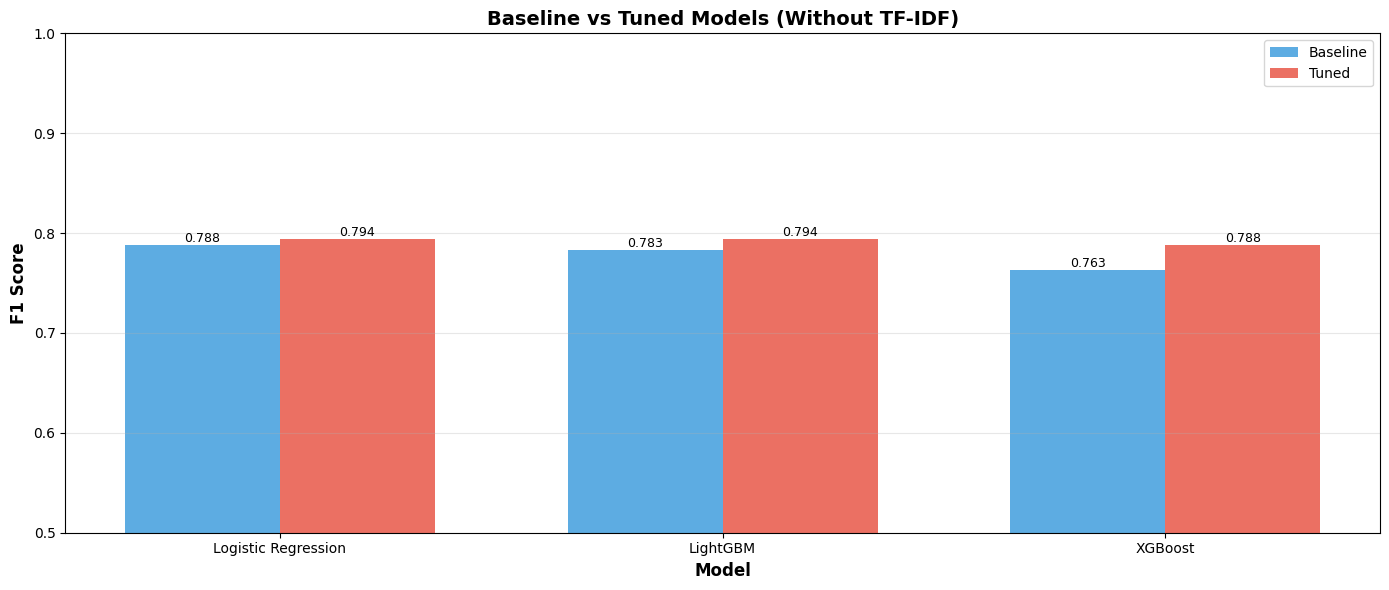

In [43]:
# Visualize baseline vs tuned comparison
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(baseline_results_df))
width = 0.35

baseline_f1 = baseline_results_df['Test F1'].values
tuned_f1 = tuned_baseline_results_df['Test F1'].values

bars1 = ax.bar(x - width/2, baseline_f1, width, label='Baseline', color='#3498db', alpha=0.8)
bars2 = ax.bar(x + width/2, tuned_f1, width, label='Tuned', color='#e74c3c', alpha=0.8)

ax.set_xlabel('Model', fontweight='bold', fontsize=12)
ax.set_ylabel('F1 Score', fontweight='bold', fontsize=12)
ax.set_title('Baseline vs Tuned Models (Without TF-IDF)', fontweight='bold', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(baseline_results_df['Model'])
ax.legend()
ax.set_ylim([0.5, 1.0])
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

Even with hyperparameter tuning, the baseline models show limited performance using only structured features. The review text contains rich information about customer satisfaction that we're currently ignoring. Let's try TF-IDF

## 5. Feature Enhancement with TF-IDF

In [44]:
print("="*80)
print("PHASE 2: EXTRACTING TF-IDF FEATURES FROM TEXT")
print("="*80)
print("\nExtracting TF-IDF features...")

tfidf = TfidfVectorizer(max_features=500, ngram_range=(1, 2), min_df=2, max_df=0.95)
tfidf_train = tfidf.fit_transform(X_train[text_column].fillna(''))
tfidf_test = tfidf.transform(X_test[text_column].fillna(''))

tfidf_train_df = pd.DataFrame(tfidf_train.toarray(),
                               columns=tfidf.get_feature_names_out(),
                               index=X_train.index)
tfidf_test_df = pd.DataFrame(tfidf_test.toarray(),
                              columns=tfidf.get_feature_names_out(),
                              index=X_test.index)

# Combine structured and text-derived features
X_train_final = pd.concat([X_train_structured.reset_index(drop=True),
                           tfidf_train_df.reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test_structured.reset_index(drop=True),
                          tfidf_test_df.reset_index(drop=True)], axis=1)

preprocessing_artifacts['tfidf_vectorizer'] = tfidf
preprocessing_artifacts['final_feature_names'] = X_train_final.columns.tolist()

print("  TF-IDF extraction completed!")
print(f"Structured features: {X_train_structured.shape[1]}")
print(f"TF-IDF features: {tfidf_train_df.shape[1]}")
print(f"Total features with TF-IDF: {X_train_final.shape[1]}")
print(f"\nFeature increase: {X_train_final.shape[1] - X_train_structured.shape[1]} additional features from text!")
print("="*80)

PHASE 2: EXTRACTING TF-IDF FEATURES FROM TEXT

Extracting TF-IDF features...
  TF-IDF extraction completed!
Structured features: 13
TF-IDF features: 500
Total features with TF-IDF: 513

Feature increase: 500 additional features from text!


## 6. Model Training with TF-IDF Features

Now let's train the same models with the enhanced feature set (structured + TF-IDF):

In [45]:
# Dictionary to store models and predictions with TF-IDF
models = {}
predictions = {}

print("="*80)
print("TRAINING MODELS WITH TF-IDF FEATURES")
print("="*80)

TRAINING MODELS WITH TF-IDF FEATURES


In [46]:
# Model 1: Logistic Regression with TF-IDF
print("\n1. Training Logistic Regression (with TF-IDF)...")
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_model.fit(X_train_final, y_train)
lr_pred = lr_model.predict(X_test_final)

models['Logistic Regression'] = lr_model
predictions['Logistic Regression'] = lr_pred

print(f"   Accuracy: {accuracy_score(y_test, lr_pred):.4f}")
print(f"   F1 Score: {f1_score(y_test, lr_pred):.4f}")
print("     Complete")


1. Training Logistic Regression (with TF-IDF)...
   Accuracy: 0.8824
   F1 Score: 0.8648
     Complete


In [47]:
# Model 2: XGBoost with TF-IDF
print("\n2. Training XGBoost (with TF-IDF)...")
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train_final, y_train)
xgb_pred = xgb_model.predict(X_test_final)

models['XGBoost'] = xgb_model
predictions['XGBoost'] = xgb_pred

print(f"   Accuracy: {accuracy_score(y_test, xgb_pred):.4f}")
print(f"   F1 Score: {f1_score(y_test, xgb_pred):.4f}")
print("     Complete")


2. Training XGBoost (with TF-IDF)...
   Accuracy: 0.8663
   F1 Score: 0.8428
     Complete


In [48]:
# Model 3: LightGBM with TF-IDF
print("\n3. Training LightGBM (with TF-IDF)...")
lgbm_model = LGBMClassifier(random_state=42, verbose=-1)
lgbm_model.fit(X_train_final, y_train)
lgbm_pred = lgbm_model.predict(X_test_final)

models['LightGBM'] = lgbm_model
predictions['LightGBM'] = lgbm_pred

print(f"   Accuracy: {accuracy_score(y_test, lgbm_pred):.4f}")
print(f"   F1 Score: {f1_score(y_test, lgbm_pred):.4f}")
print("     Complete")

print("\n" + "="*80)
print("ALL MODELS WITH TF-IDF TRAINED SUCCESSFULLY!")
print("="*80)


3. Training LightGBM (with TF-IDF)...


   Accuracy: 0.8752
   F1 Score: 0.8511
     Complete

ALL MODELS WITH TF-IDF TRAINED SUCCESSFULLY!


## 7. Comprehensive Model Comparison

### Understanding Training vs Test Performance

**Why report both?**
- **Training scores** show how well the model learned from the training data
- **Test scores** show how well the model generalizes to unseen data
- **The gap** between them indicates overfitting or good generalization:
  - Gap > 0.1: Overfitting (model memorized training data)
  - Gap 0.05-0.1: Good fit (acceptable generalization)
  - Gap < 0.05: Excellent fit (strong generalization)

This analysis helps ensure our model will perform well in production on new airline reviews.


MODEL PERFORMANCE WITH TF-IDF FEATURES - TRAINING vs TEST
              Model  Train Accuracy  Test Accuracy  Train F1  Test F1  Train Precision  Test Precision  Train Recall  Test Recall
Logistic Regression        0.886364       0.884135  0.871017 0.867076         0.858425        0.861789      0.883984     0.872428
           LightGBM        1.000000       0.875223  1.000000 0.851064         1.000000        0.881057      1.000000     0.823045
            XGBoost        1.000000       0.866310  1.000000 0.842767         1.000000        0.858974      1.000000     0.827160

 BEST MODEL: Logistic Regression
   TRAINING SET:
     Accuracy:  0.8864
     Precision: 0.8584
     Recall:    0.8840
     F1 Score:  0.8710

   TEST SET:
     Accuracy:  0.8841
     Precision: 0.8618
     Recall:    0.8724
     F1 Score:  0.8671

   GENERALIZATION:
     Train-Test F1 Gap: 0.0039 (Excellent generalization)


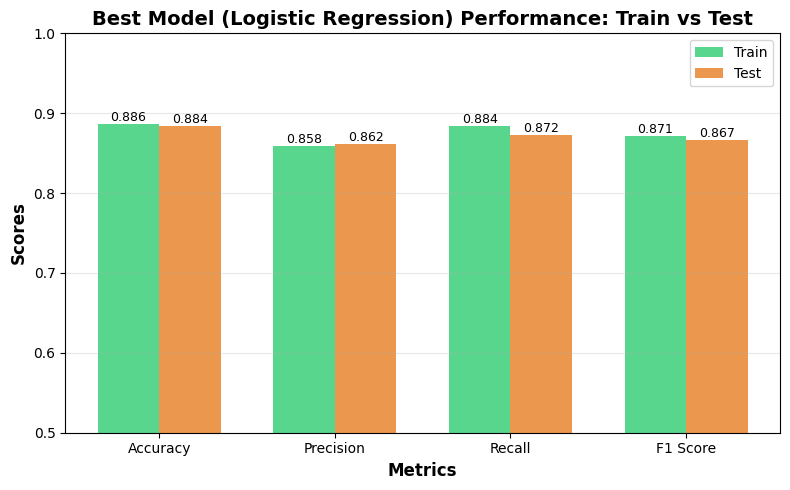

In [58]:
# Calculate metrics for models with TF-IDF (both training and test)
results = []

for model_name, pred in predictions.items():
    model = models[model_name]
    train_pred = model.predict(X_train_final)
    
    results.append({
        'Model': model_name,
        'Train Accuracy': accuracy_score(y_train, train_pred),
        'Test Accuracy': accuracy_score(y_test, pred),
        'Train F1': f1_score(y_train, train_pred),
        'Test F1': f1_score(y_test, pred),
        'Train Precision': precision_score(y_train, train_pred),
        'Test Precision': precision_score(y_test, pred),
        'Train Recall': recall_score(y_train, train_pred),
        'Test Recall': recall_score(y_test, pred)
    })

results_df = pd.DataFrame(results).sort_values('Test F1', ascending=False)

print("\n" + "="*110)
print("MODEL PERFORMANCE WITH TF-IDF FEATURES - TRAINING vs TEST")
print("="*110)
print(results_df.to_string(index=False))
print("="*110)

# Identify best model
best_model_name = results_df.iloc[0]['Model']
best_model_metrics = results_df.iloc[0]

print(f"\n BEST MODEL: {best_model_name}")
print(f"   TRAINING SET:")
print(f"     Accuracy:  {best_model_metrics['Train Accuracy']:.4f}")
print(f"     Precision: {best_model_metrics['Train Precision']:.4f}")
print(f"     Recall:    {best_model_metrics['Train Recall']:.4f}")
print(f"     F1 Score:  {best_model_metrics['Train F1']:.4f}")
print(f"\n   TEST SET:")
print(f"     Accuracy:  {best_model_metrics['Test Accuracy']:.4f}")
print(f"     Precision: {best_model_metrics['Test Precision']:.4f}")
print(f"     Recall:    {best_model_metrics['Test Recall']:.4f}")
print(f"     F1 Score:  {best_model_metrics['Test F1']:.4f}")
print(f"\n   GENERALIZATION:")
train_test_gap = best_model_metrics['Train F1'] - best_model_metrics['Test F1']
status = "Overfitting detected" if train_test_gap > 0.1 else "Good generalization" if train_test_gap > 0.05 else "Excellent generalization"
print(f"     Train-Test F1 Gap: {train_test_gap:.4f} ({status})")

# plot the best model test vs train metrics using a bar chart
fig, ax = plt.subplots(figsize=(8, 5))
x = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
train_metrics = [best_model_metrics['Train Accuracy'],
                 best_model_metrics['Train Precision'],
                 best_model_metrics['Train Recall'],
                 best_model_metrics['Train F1']]
test_metrics = [best_model_metrics['Test Accuracy'],
                best_model_metrics['Test Precision'],
                best_model_metrics['Test Recall'],
                best_model_metrics['Test F1']]

x_indices = np.arange(len(x))
width = 0.35
bars1 = ax.bar(x_indices - width/2, train_metrics, width, label='Train', color='#2ecc71', alpha=0.8)
bars2 = ax.bar(x_indices + width/2, test_metrics, width, label='Test', color='#e67e22', alpha=0.8)
ax.set_xlabel('Metrics', fontweight='bold', fontsize=12)
ax.set_ylabel('Scores', fontweight='bold', fontsize=12)
ax.set_title(f'Best Model ({best_model_name}) Performance: Train vs Test', fontweight='bold', fontsize=14)
ax.set_xticks(x_indices)
ax.set_xticklabels(x)
ax.legend()
ax.set_ylim([0.5, 1.0])
ax.grid(axis='y', alpha=0.3)
# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

In [50]:
# Compare all three approaches: Baseline, Tuned Baseline, and With TF-IDF (Test F1 scores)
comparison_data = []

for model_name in ['Logistic Regression', 'XGBoost', 'LightGBM']:
    # Baseline
    baseline_f1 = baseline_results_df[baseline_results_df['Model'] == model_name]['Test F1'].values[0]
    # Tuned Baseline
    tuned_f1 = tuned_baseline_results_df[tuned_baseline_results_df['Model'] == model_name]['Test F1'].values[0]
    # With TF-IDF
    tfidf_f1 = results_df[results_df['Model'] == model_name]['Test F1'].values[0]
    
    comparison_data.append({
        'Model': model_name,
        'Baseline (No Tuning)': baseline_f1,
        'Tuned Baseline (No TF-IDF)': tuned_f1,
        'With TF-IDF': tfidf_f1,
        'Improvement': tfidf_f1 - tuned_f1
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*100)
print("COMPLETE COMPARISON: BASELINE → TUNED → WITH TF-IDF (Test F1 Scores)")
print("="*100)
print(comparison_df.to_string(index=False))
print("="*100)
print(f"\nAverage improvement with TF-IDF: {comparison_df['Improvement'].mean():.4f}")


COMPLETE COMPARISON: BASELINE → TUNED → WITH TF-IDF (Test F1 Scores)
              Model  Baseline (No Tuning)  Tuned Baseline (No TF-IDF)  With TF-IDF  Improvement
Logistic Regression              0.787763                    0.787763     0.864754     0.076991
            XGBoost              0.762712                    0.793587     0.842767     0.049180
           LightGBM              0.782979                    0.794411     0.851064     0.056653

Average improvement with TF-IDF: 0.0609


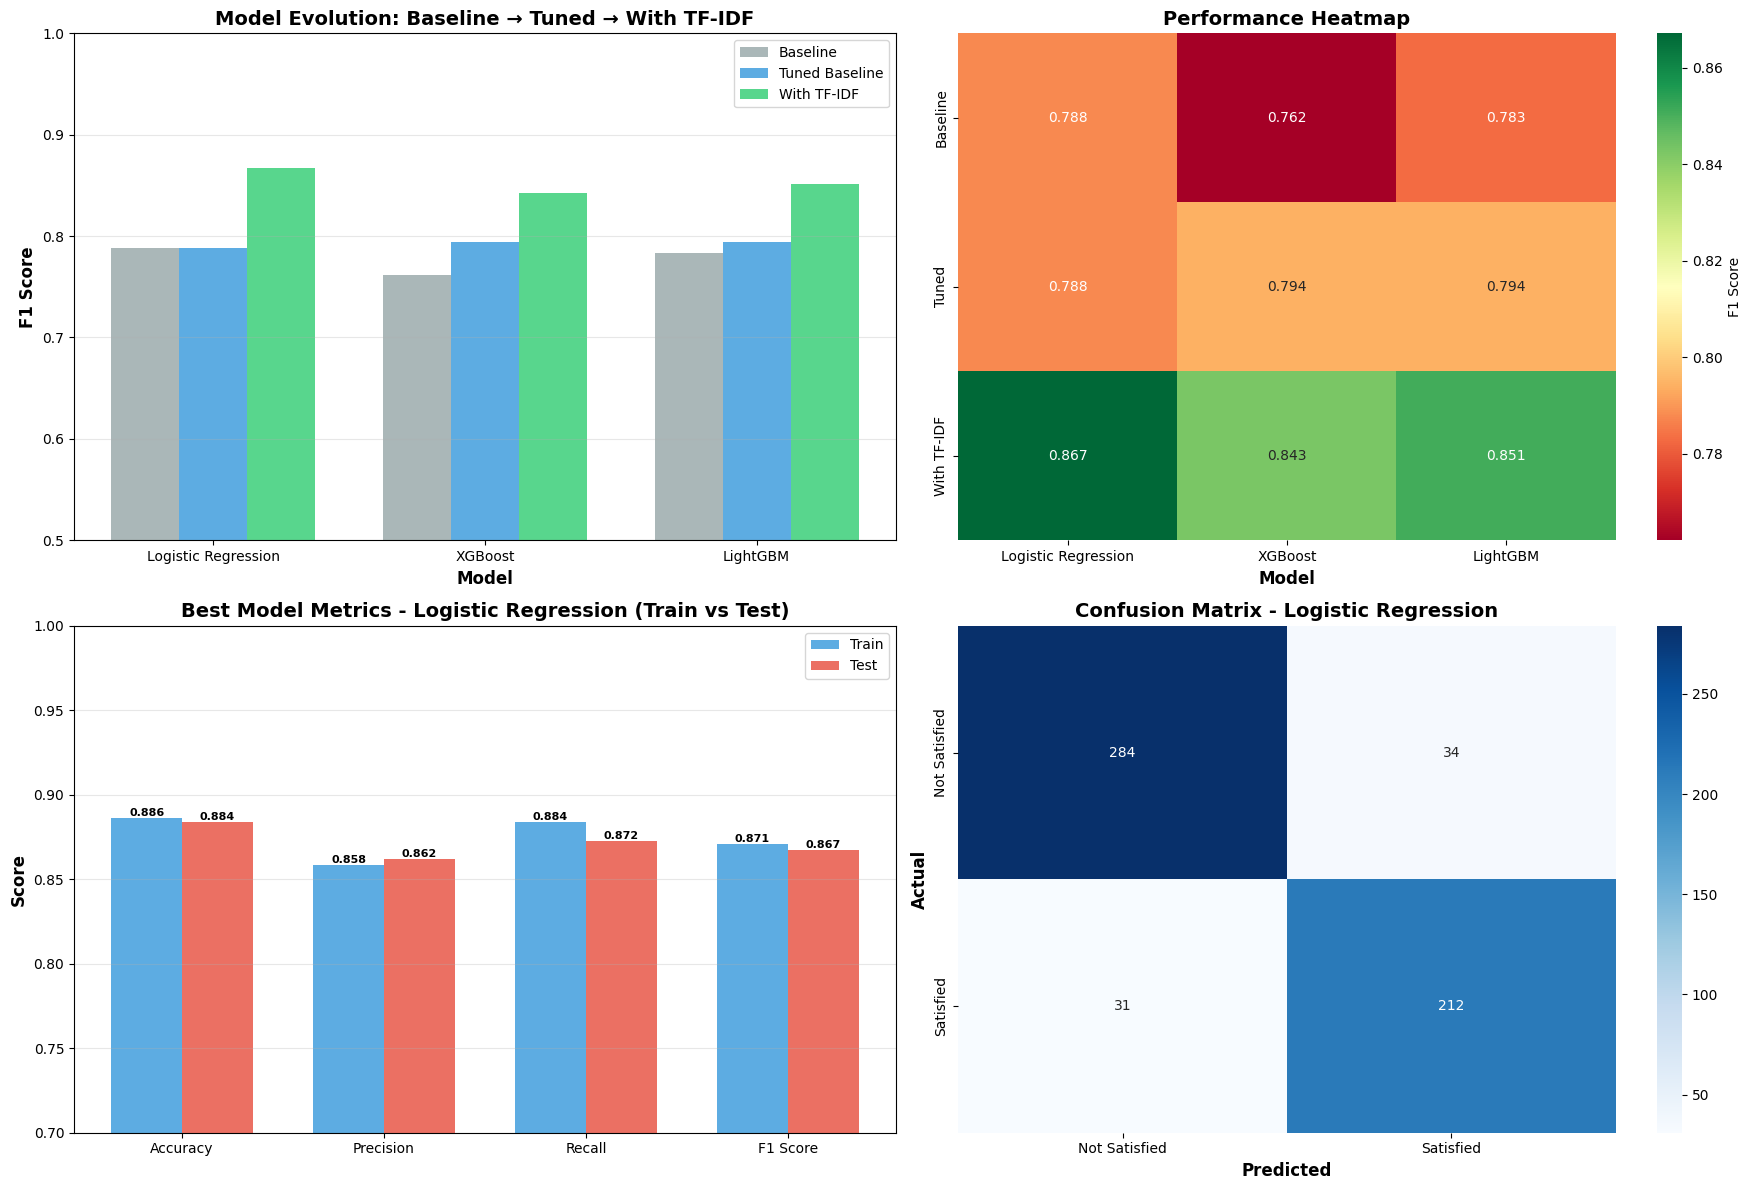

In [51]:
# Comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Grouped bar chart showing progression
ax1 = axes[0, 0]
x = np.arange(len(comparison_df))
width = 0.25

bars1 = ax1.bar(x - width, comparison_df['Baseline (No Tuning)'], width, label='Baseline', color='#95a5a6', alpha=0.8)
bars2 = ax1.bar(x, comparison_df['Tuned Baseline (No TF-IDF)'], width, label='Tuned Baseline', color='#3498db', alpha=0.8)
bars3 = ax1.bar(x + width, comparison_df['With TF-IDF'], width, label='With TF-IDF', color='#2ecc71', alpha=0.8)

ax1.set_xlabel('Model', fontweight='bold', fontsize=12)
ax1.set_ylabel('F1 Score', fontweight='bold', fontsize=12)
ax1.set_title('Model Evolution: Baseline → Tuned → With TF-IDF', fontweight='bold', fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(comparison_df['Model'])
ax1.legend()
ax1.set_ylim([0.5, 1.0])
ax1.grid(axis='y', alpha=0.3)

# 2. Improvement heatmap
ax2 = axes[0, 1]
improvement_matrix = comparison_df[['Baseline (No Tuning)', 'Tuned Baseline (No TF-IDF)', 'With TF-IDF']].T
sns.heatmap(improvement_matrix, annot=True, fmt='.3f', cmap='RdYlGn', ax=ax2, 
            xticklabels=comparison_df['Model'], 
            yticklabels=['Baseline', 'Tuned', 'With TF-IDF'],
            cbar_kws={'label': 'F1 Score'})
ax2.set_title('Performance Heatmap', fontweight='bold', fontsize=14)
ax2.set_xlabel('Model', fontweight='bold', fontsize=12)

# 3. Metrics comparison for best model with TF-IDF (Train vs Test)
ax3 = axes[1, 0]
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
train_values = [
    results_df.iloc[0]['Train Accuracy'],
    results_df.iloc[0]['Train Precision'],
    results_df.iloc[0]['Train Recall'],
    results_df.iloc[0]['Train F1']
]
test_values = [
    results_df.iloc[0]['Test Accuracy'],
    results_df.iloc[0]['Test Precision'],
    results_df.iloc[0]['Test Recall'],
    results_df.iloc[0]['Test F1']
]

x_pos = np.arange(len(metrics_names))
width = 0.35

bars1 = ax3.bar(x_pos - width/2, train_values, width, label='Train', color='#3498db', alpha=0.8)
bars2 = ax3.bar(x_pos + width/2, test_values, width, label='Test', color='#e74c3c', alpha=0.8)

ax3.set_ylabel('Score', fontweight='bold', fontsize=12)
ax3.set_title(f'Best Model Metrics - {best_model_name} (Train vs Test)', fontweight='bold', fontsize=14)
ax3.set_xticks(x_pos)
ax3.set_xticklabels(metrics_names)
ax3.set_ylim([0.7, 1.0])
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=8, fontweight='bold')

# 4. Confusion matrix for best model
ax4 = axes[1, 1]
best_pred = predictions[best_model_name]
cm = confusion_matrix(y_test, best_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax4, 
            xticklabels=['Not Satisfied', 'Satisfied'], 
            yticklabels=['Not Satisfied', 'Satisfied'])
ax4.set_ylabel('Actual', fontweight='bold', fontsize=12)
ax4.set_xlabel('Predicted', fontweight='bold', fontsize=12)
ax4.set_title(f'Confusion Matrix - {best_model_name}', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.show()

In [52]:
# Detailed classification report for best model
print("\n" + "="*80)
print(f"DETAILED CLASSIFICATION REPORT - {best_model_name}")
print("="*80)
print(classification_report(y_test, predictions[best_model_name], 
                          target_names=['Not Satisfied', 'Satisfied']))
print("="*80)


DETAILED CLASSIFICATION REPORT - Logistic Regression
               precision    recall  f1-score   support

Not Satisfied       0.90      0.89      0.90       318
    Satisfied       0.86      0.87      0.86       243

     accuracy                           0.88       561
    macro avg       0.88      0.88      0.88       561
 weighted avg       0.88      0.88      0.88       561



## 8. Model Interpretability Analysis
### SHAP


MODEL INTERPRETABILITY - Logistic Regression


Generating SHAP summary plot...


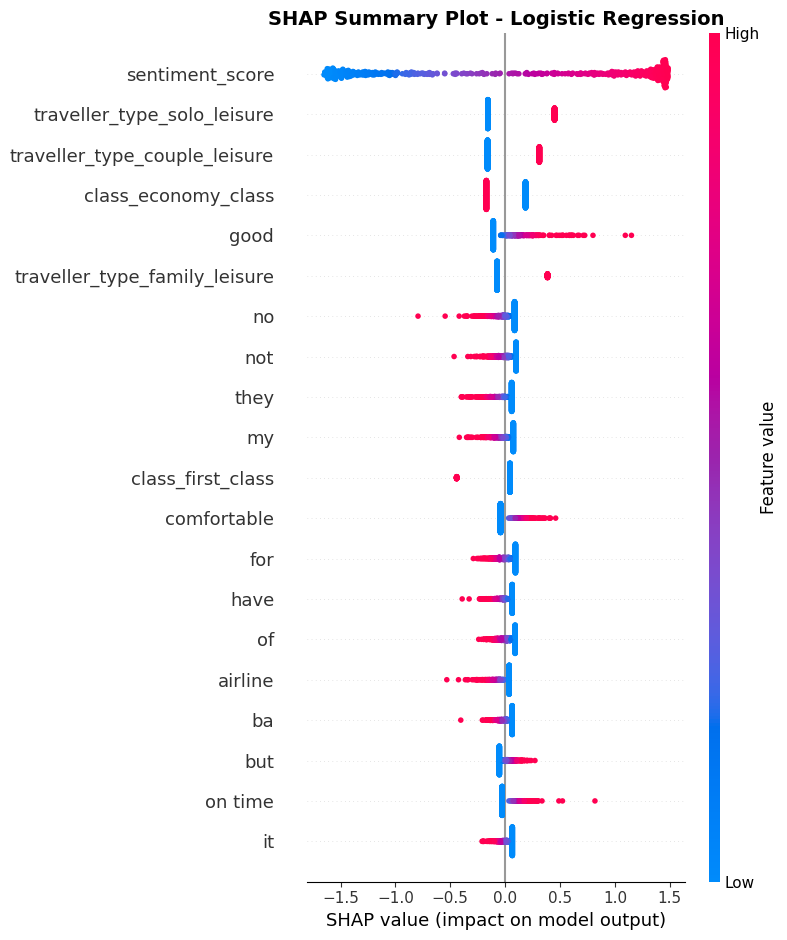

Running SHAP on a representative instance...


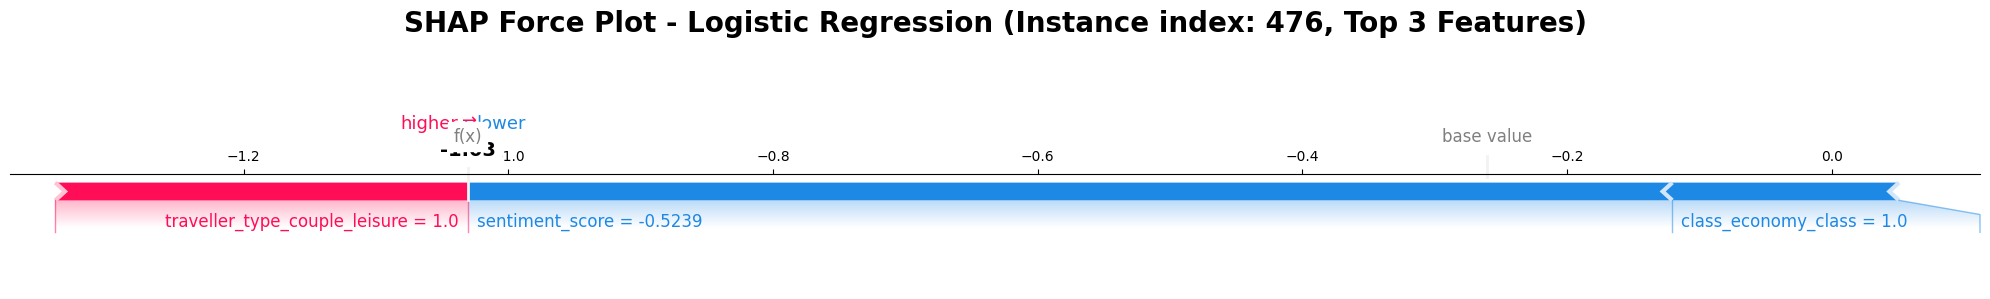

In [53]:
# SHAP and LIME interpretability for the chosen best model
print("\n" + "="*80)
print(f"MODEL INTERPRETABILITY - {best_model_name}")
print("="*80)

shap.initjs()
best_model = models[best_model_name]

# Sample a manageable subset for explainability plots
sample_size = len(X_test_final)
# Set random seed for reproducibility
np.random.seed(42)

X_sample = X_test_final

print("Generating SHAP summary plot...")
if best_model_name in ['XGBoost', 'LightGBM']:
    shap_explainer = shap.TreeExplainer(best_model)
    shap_values = shap_explainer.shap_values(X_sample)
else:
    shap_explainer = shap.LinearExplainer(best_model, X_train_final, feature_perturbation="interventional")
    shap_values = shap_explainer.shap_values(X_sample)

shap_values_to_plot = shap_values[1] if isinstance(shap_values, list) and len(shap_values) > 1 else shap_values
shap.summary_plot(shap_values_to_plot, X_sample, show=False)
plt.title(f"SHAP Summary Plot - {best_model_name}", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Choose a single instance for deeper SHAP inspection
print("Running SHAP on a representative instance...")
instance_position = 476
instance_features = X_sample.iloc[instance_position]
instance_shap_values = shap_values_to_plot[instance_position]

expected_value = shap_explainer.expected_value
if isinstance(expected_value, (list, np.ndarray)):
    expected_array = np.array(expected_value).flatten()
    expected_value = expected_array[1] if expected_array.size > 1 else expected_array[0]

# Get top features by absolute SHAP value
top_n_features = 3  # Adjust this number to show more/fewer features
feature_importance = pd.Series(np.abs(instance_shap_values), index=instance_features.index)
top_features_idx = feature_importance.nlargest(top_n_features).index
top_features_mask = instance_features.index.isin(top_features_idx)

# Filter to top features for better labeling
filtered_features = instance_features[top_features_mask]
filtered_shap_values = instance_shap_values[top_features_mask]

shap.force_plot(expected_value, filtered_shap_values, filtered_features, matplotlib=True, show=False)
plt.gcf().suptitle(
    f"SHAP Force Plot - {best_model_name} (Instance index: {instance_features.name}, Top {top_n_features} Features)",
    fontsize=20,
    fontweight='bold'
 )
plt.tight_layout()
plt.show()



First SHAP plot:
* The sentiment score is by far the strongest predictor, with positive sentiment (magenta) driving satisfaction far more than any demographic or service feature.
* Solo/couple leisure travelers and positive descriptors ("good", "comfortable") modestly boost predictions, while negative language ("not", "no") and economy class slightly decrease them however, sentiment is more important.

Second SHAP plot:
This force plot shows a single prediction where the model predicts dissatisfaction. The negative sentiment score (-0.52) pushes the prediction strongly leftward (blue arrows) toward the "lower" (dissatisfied) outcome, overwhelming the base value and driving the final prediction further negative. This individual case confirms sentiment's dominant predictive power seen in the summary plot.

### LIME

Generating LIME explanation for index 476 


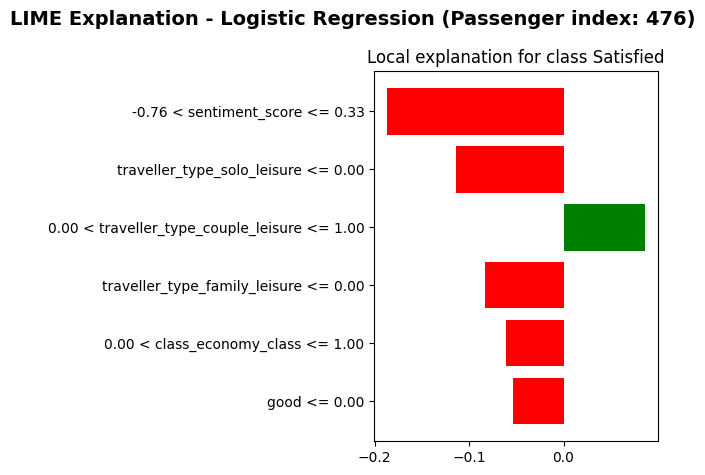


Top feature contributions (positive values push toward 'Satisfied'):
  -0.76 < sentiment_score <= 0.33               -0.187 (toward 'Not Satisfied')
  traveller_type_solo_leisure <= 0.00           -0.114 (toward 'Not Satisfied')
  0.00 < traveller_type_couple_leisure <= 1.00  +0.086 (toward 'Satisfied')
  traveller_type_family_leisure <= 0.00         -0.084 (toward 'Not Satisfied')
  0.00 < class_economy_class <= 1.00            -0.061 (toward 'Not Satisfied')
  good <= 0.00                                  -0.054 (toward 'Not Satisfied')


In [54]:

print(f"Generating LIME explanation for index {instance_features.name} ")
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    X_train_final.values,
    feature_names=X_train_final.columns.tolist(),
    class_names=['Not Satisfied', 'Satisfied'],
    discretize_continuous=True
 )

instance_index = int(instance_features.name)
exp_lime = explainer_lime.explain_instance(
    X_test_final.loc[instance_index].values,
    best_model.predict_proba,
    num_features=6
 )

try:
    exp_lime.show_in_notebook(show_table=True)
except Exception:
    display(HTML(exp_lime.as_html()))

lime_fig = exp_lime.as_pyplot_figure()
lime_fig.patch.set_facecolor("white")
for axis in lime_fig.axes:
    axis.set_facecolor("white")
lime_fig.suptitle(
    f"LIME Explanation - {best_model_name} (Passenger index: {instance_index})",
    fontsize=14,
    fontweight='bold'
 )
plt.tight_layout()
plt.show()

lime_weights = exp_lime.as_list()
print("\nTop feature contributions (positive values push toward 'Satisfied'):")
for feature, weight in lime_weights:
    direction = "toward 'Satisfied'" if weight > 0 else "toward 'Not Satisfied'"
    print(f"  {feature:<45} {weight:+.3f} ({direction})")


This LIME plot explains the same dissatisfied prediction (80% Not Satisfied, 20% Satisfied). The negative sentiment score (-0.52) is again the primary driver pushing toward dissatisfaction. LIME confirms what SHAP showed: sentiment dominates the prediction for this individual case.


--------------------------------------------------------------------------------
LOGISTIC REGRESSION INTERPRETABILITY
--------------------------------------------------------------------------------


,Feature,Coefficient,Impact
0,good,2.902161,Positive
1,comfortable,2.037409,Positive
2,on time,1.887806,Positive
3,drinks,1.756400,Positive
4,sentiment_score,1.573171,Positive
5,was good,1.499425,Positive
6,excellent,1.491810,Positive
7,friendly,1.399572,Positive
8,efficient,1.388014,Positive
9,ife,1.351208,Positive


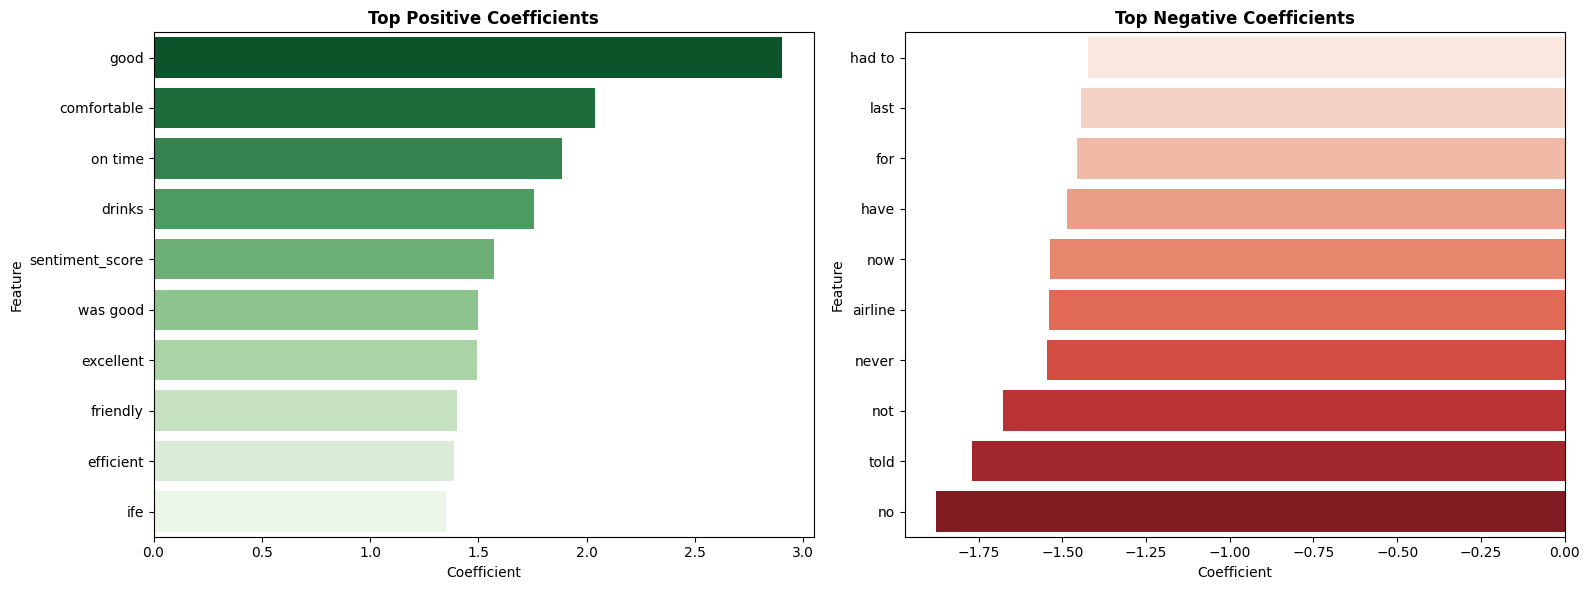

In [55]:
# Logistic Regression specific interpretability
print("\n" + "-"*80)
print("LOGISTIC REGRESSION INTERPRETABILITY")
print("-"*80)

logistic_model = models.get('Logistic Regression')
if logistic_model is None:
    print("Logistic Regression model is not available in the current session.")
else:
    coef_series = pd.Series(logistic_model.coef_.ravel(), index=X_train_final.columns)
    coef_series = coef_series.sort_values(ascending=False)
    top_positive = coef_series.head(10)
    top_negative = coef_series.tail(10)

    coef_summary = pd.concat([
        pd.DataFrame({'Feature': top_positive.index, 'Coefficient': top_positive.values, 'Impact': 'Positive'}),
        pd.DataFrame({'Feature': top_negative.index, 'Coefficient': top_negative.values, 'Impact': 'Negative'})
    ])
    display(coef_summary)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    sns.barplot(x=top_positive.values, y=top_positive.index, ax=axes[0], palette='Greens_r')
    axes[0].set_title('Top Positive Coefficients', fontweight='bold')
    axes[0].set_xlabel('Coefficient')
    axes[0].set_ylabel('Feature')

    sns.barplot(x=top_negative.values, y=top_negative.index, ax=axes[1], palette='Reds')
    axes[1].set_title('Top Negative Coefficients', fontweight='bold')
    axes[1].set_xlabel('Coefficient')
    axes[1].set_ylabel('Feature')

    plt.tight_layout()
    plt.show()

    

This coefficient plot reveals the logistic regression model's learned weights for predicting airline satisfaction.

Words like "good", "comfortable", "on time", and "drinks" increase satisfaction probability.

Negation words like "no", "not", and "never" are the strongest negative predictors. This is because they capture customer frustration.

## 9. Save Model Artifacts for Inference

We'll save all necessary components for inference:
- The trained best model
- TF-IDF vectorizer
- Encoder
- Feature names and preprocessing metadata

In [56]:
import joblib
import json

# Create a models directory if it doesn't exist
models_dir = "models"
os.makedirs(models_dir, exist_ok=True)

print("\nSAVING MODEL ARTIFACTS FOR INFERENCE")

# 1. Save the best model
model_path = os.path.join(models_dir, f"{best_model_name.lower().replace(' ', '_')}_model.pkl")
joblib.dump(best_model, model_path)
print(f"\nBest model saved: {model_path}")

# 2. Save the TF-IDF vectorizer
tfidf_path = os.path.join(models_dir, "tfidf_vectorizer.pkl")
joblib.dump(preprocessing_artifacts['tfidf_vectorizer'], tfidf_path)
print(f"\nTF-IDF vectorizer saved: {tfidf_path}")

# 3. Save ordinal encoder if it exists
if 'layover_route_encoder' in preprocessing_artifacts:
    encoder_path = os.path.join(models_dir, "ordinal_encoder.pkl")
    joblib.dump(preprocessing_artifacts['layover_route_encoder'], encoder_path)
    print(f"\nOrdinal encoder saved: {encoder_path}")

# 4. Save preprocessing metadata
metadata = {
    'best_model_name': best_model_name,
    'structured_feature_names': preprocessing_artifacts['structured_feature_names'],
    'final_feature_names': preprocessing_artifacts['final_feature_names'],
    'text_column': text_column,
    'columns_to_drop': columns_to_drop,
    'model_performance': {
        'train_accuracy': float(best_model_metrics['Train Accuracy']),
        'test_accuracy': float(best_model_metrics['Test Accuracy']),
        'train_precision': float(best_model_metrics['Train Precision']),
        'test_precision': float(best_model_metrics['Test Precision']),
        'train_recall': float(best_model_metrics['Train Recall']),
        'test_recall': float(best_model_metrics['Test Recall']),
        'train_f1_score': float(best_model_metrics['Train F1']),
        'test_f1_score': float(best_model_metrics['Test F1']),
        'train_test_gap': float(best_model_metrics['Train F1'] - best_model_metrics['Test F1'])
    }
}

metadata_path = os.path.join(models_dir, "preprocessing_metadata.json")
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=4)
print(f"Preprocessing metadata saved: {metadata_path}")

print("\n ALL MODEL ARTIFACTS SAVED SUCCESSFULLY!")
print(f"\nSaved files:")
print(f"  - {model_path}")
print(f"  - {tfidf_path}")
if 'layover_route_encoder' in preprocessing_artifacts:
    print(f"  - {encoder_path}")
print(f"  - {metadata_path}")



SAVING MODEL ARTIFACTS FOR INFERENCE

Best model saved: models\logistic_regression_model.pkl

TF-IDF vectorizer saved: models\tfidf_vectorizer.pkl

Ordinal encoder saved: models\ordinal_encoder.pkl
Preprocessing metadata saved: models\preprocessing_metadata.json

 ALL MODEL ARTIFACTS SAVED SUCCESSFULLY!

Saved files:
  - models\logistic_regression_model.pkl
  - models\tfidf_vectorizer.pkl
  - models\ordinal_encoder.pkl
  - models\preprocessing_metadata.json
